In [102]:
import pymongo
import seaborn as sns
%matplotlib inline

In [4]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [5]:
client = pymongo.MongoClient()
db = client.metrics

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [244]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "window_size":    "$parameters.window_size",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

In [246]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(10)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,window_size,hs_feats
0,58049679c1a7cb44222ddd3b,2016-10-17 04:14:33.083,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.828318,0.886428,0.777359,0.822510,11,extract_brown_cluster|extract_dependency_relat...
1,5804e5d8c1a7cb44222dddc1,2016-10-17 09:53:12.950,6,"[fn_pos_wd_feats_stemmed[offset:6], fn_pos_ngr...",0.827998,0.887581,0.775911,0.821827,13,extract_brown_cluster|extract_dependency_relat...
2,580445e4c1a7cb44222ddcbd,2016-10-16 22:30:44.677,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827891,0.884965,0.777733,0.822128,9,extract_brown_cluster|extract_dependency_relat...
3,58044d32c1a7cb44222ddcc3,2016-10-16 23:01:54.576,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827796,0.885654,0.777034,0.821831,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
4,5804358ec1a7cb44222ddcad,2016-10-16 21:21:02.512,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827714,0.884882,0.777484,0.821858,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
5,580490c2c1a7cb44222ddd35,2016-10-17 03:50:10.217,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827713,0.884654,0.777658,0.821803,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
6,5804e24dc1a7cb44222dddbd,2016-10-17 09:38:05.614,6,"[fn_pos_wd_feats_stemmed[offset:6], fn_pos_ngr...",0.827645,0.887163,0.775611,0.821416,13,extract_brown_cluster|extract_dependency_relat...
7,5804871cc1a7cb44222ddd2b,2016-10-17 03:09:00.384,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827558,0.885627,0.776635,0.821638,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
8,58043dd9c1a7cb44222ddcb7,2016-10-16 21:56:25.404,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.827528,0.884136,0.777733,0.821848,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
9,580492f6c1a7cb44222ddd37,2016-10-17 03:59:34.101,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.827457,0.884554,0.777284,0.821547,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...


In [250]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,window_size".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, win_size = 11):
    df_top_individual_feats = df[(df["count"] == 1) & (df["window_size"] == win_size)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, 11)

In [254]:
a, b = get_top_individual_feats(cb_vd_df, 11), get_top_individual_feats(sc_vd_df, 11)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[],0.817206,0.755861,0.889388,pos_wd_feats_stemmed[],0.799083,0.750906,0.853866
1,2,pos_wd_feats[],0.811229,0.744601,0.890954,pos_wd_feats[],0.795905,0.743765,0.855906
2,3,pos_ngram_feat_stemmed[ngram_size:2],0.779349,0.681831,0.909418,pos_ngram_feat_stemmed[ngram_size:2],0.770860,0.691597,0.870642
3,4,pos_ngram_feat[ngram_size:2],0.762352,0.657262,0.907443,pos_ngram_feat[ngram_size:2],0.762870,0.680177,0.868453
4,5,pos_ngram_feat_stemmed[ngram_size:3],0.717195,0.587002,0.921599,pos_ngram_feat_stemmed[ngram_size:3],0.708871,0.594674,0.877352
5,6,pos_ngram_feat[ngram_size:3],0.692890,0.556590,0.917593,pos_ngram_feat[ngram_size:3],0.698335,0.580201,0.876874
6,7,bow_ngram_feat[ngram_size:2],0.568969,0.452947,0.764894,extract_dependency_relation,0.576761,0.472921,0.739032
7,8,extract_dependency_relation,0.565484,0.422436,0.855013,bow_ngram_feat[ngram_size:2],0.550884,0.441740,0.731660
8,9,bow_ngram_feat[ngram_size:1],0.558441,0.468228,0.691712,bow_ngram_feat[ngram_size:3],0.524022,0.391371,0.792702
9,10,bow_ngram_feat[ngram_size:3],0.527211,0.389179,0.816972,bow_ngram_feat[ngram_size:1],0.509915,0.417727,0.654314


## Generate Rows for LaTex Table

In [166]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & pos wd feats stemmed & 0.817 & & pos wd feats stemmed & 0.799\\
2 & pos wd feats & 0.811 & & pos wd feats & 0.796\\
3 & pos ngram feat stemmed ngram size:2 & 0.779 & & pos ngram feat stemmed ngram size:2 & 0.771\\
4 & pos ngram feat ngram size:2 & 0.762 & & pos ngram feat ngram size:2 & 0.763\\
5 & pos ngram feat stemmed ngram size:3 & 0.717 & & pos ngram feat stemmed ngram size:3 & 0.709\\
6 & pos ngram feat ngram size:3 & 0.693 & & pos ngram feat ngram size:3 & 0.698\\
7 & bow ngram feat ngram size:2 & 0.569 & & extract dependency relation & 0.577\\
8 & extract dependency relation & 0.565 & & bow ngram feat ngram size:2 & 0.551\\
9 & bow ngram feat ngram size:1 & 0.558 & & bow ngram feat ngram size:3 & 0.524\\
10 & bow ngram feat ngram size:3 & 0.527 & & bow ngram feat ngram size:1 & 0.510\\
11 & extract brown cluster & 0.360 & & pos POS feats & 0.376\\
12 & pos POS feats & 0.241 & & extract brown cluster & 0.326\\
13 & bow POS feats & 0.060 & & bow POS feats & 0.072\\


## Perfomance By Window Size

In [112]:
def get_by_window_size(df):
    return group_by(df, bycols=["window_size"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("window_size")

by_win_size = pd.merge(get_by_window_size(cb_vd_df), get_by_window_size(sc_vd_df), on="window_size", suffixes=["_CB", "_SC"])
by_win_size

,window_size,max(micro_f1_score)_CB,max(micro_f1_score)_SC
0,1,0.709742,0.709962
1,3,0.777346,0.761179
2,5,0.812873,0.791733
3,7,0.825479,0.804179
4,9,0.827891,0.806720
5,11,0.828318,0.807294
6,13,0.827998,0.806508
7,15,0.825786,0.805114


## Plot TD vs VD F1 Score For CB By Window Size

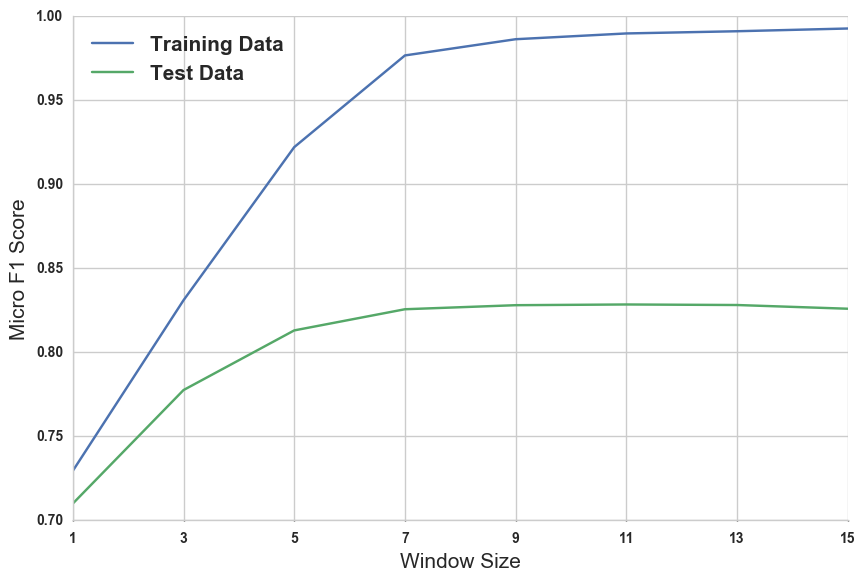

In [233]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(cb_td_df), 
    get_by_window_size(cb_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/cb_f1_vs_win_size.png")
plt.show()

## Plot TD vs VD F1 Score For SC By Window Size

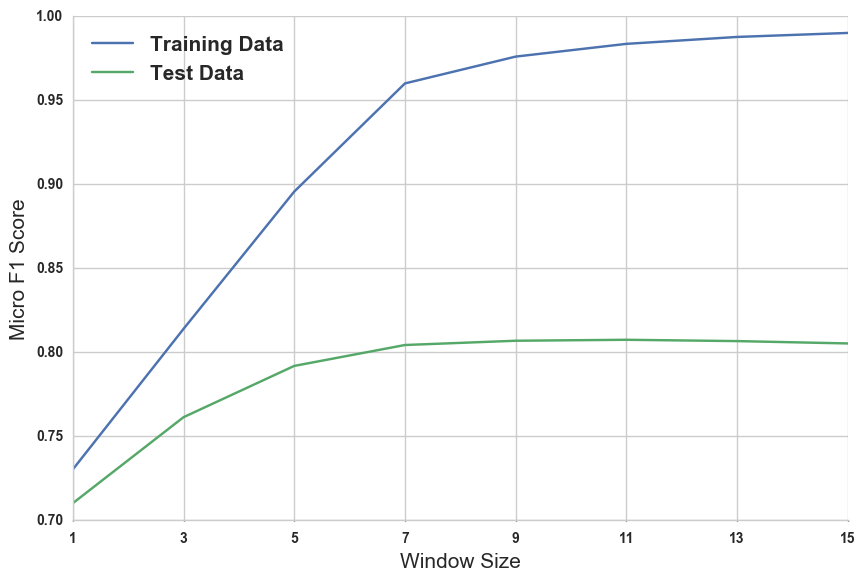

In [235]:
FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(sc_td_df), 
    get_by_window_size(sc_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sc_f1_vs_win_size.png")
plt.show()

## Performance By Feature Set Size

In [11]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count")

,count,max(micro_f1_score)_x,mean(micro_f1_score)_x,max(micro_f1_score)_y,mean(micro_f1_score)_y
0,1,0.817206,0.565948,0.799380,0.558362
1,2,0.823682,0.793374,0.804093,0.776986
2,3,0.826363,0.803536,0.806546,0.785991
3,4,0.827305,0.808519,0.806762,0.789886
4,5,0.827714,0.811045,0.807117,0.792022
5,6,0.828318,0.812727,0.807294,0.793117


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [249]:
cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision".split(",")

def get_f1_by_feat_count(df):
    top_feats = df.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]

    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", suffixes=("_CB", "_SC"))
df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,new_feat_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[],0.817206,0.755861,0.889388,pos_wd_feats_stemmed[],0.799083,0.750906,0.853866
1,2,pos_ngram_feat_stemmed[ngram_size:3],0.822854,0.759082,0.898325,pos_ngram_feat_stemmed[ngram_size:2],0.804093,0.754913,0.860129
2,3,bow_ngram_feat[ngram_size:1],0.824505,0.774912,0.880879,bow_ngram_feat[ngram_size:1],0.806546,0.765052,0.852798
3,4,pos_ngram_feat_stemmed[ngram_size:2],0.827008,0.774787,0.886777,extract_dependency_relation,0.806762,0.764861,0.853519
4,5,extract_brown_cluster,0.827558,0.776635,0.885627,extract_brown_cluster,0.807117,0.766551,0.852217
5,6,extract_dependency_relation,0.828318,0.777359,0.886428,pos_ngram_feat_stemmed[ngram_size:3],0.807294,0.765025,0.854507


# Plot F1 Score Against # Feature Sets

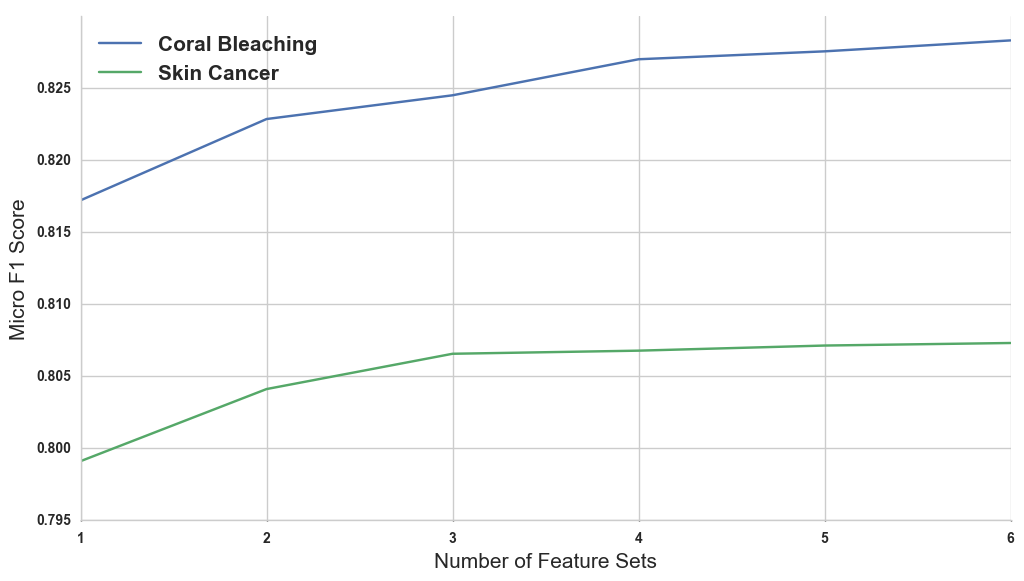

In [238]:
FONT_SIZE = 15

df = df_f1_score_by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
ax1.set_ylim([0.795, 0.83])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

In [216]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["new_feat_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & pos wd feats stemmed & 0.817 & & pos wd feats stemmed & 0.799\\
2 & pos ngram feat stemmed ngram size:3 & 0.823 & & pos ngram feat stemmed ngram size:2 & 0.804\\
3 & bow ngram feat ngram size:1 & 0.825 & & bow ngram feat ngram size:1 & 0.807\\
4 & pos ngram feat stemmed ngram size:2 & 0.827 & & extract dependency relation & 0.807\\
5 & extract brown cluster & 0.828 & & extract brown cluster & 0.807\\
6 & extract dependency relation & 0.828 & & pos ngram feat stemmed ngram size:3 & 0.807\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [247]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"